## NARX SST Región Niño 3.4

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
from MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

from tensorflow import keras

# Creando Coenxión con Mongo DB

In [2]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['polygons', 'meteorological', 'SSTNino34']

# Descargando la Información SST NIÑO3.4

In [3]:
# Fecha actual
time = datetime.today().toordinal()

# Realizando consulta
sst_data = db.SSTNino34.find({"time":{"$lte":time}})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in sst_data])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head(10)

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022
2022-01-01,62e6d1d870bebdf1983a27a4,2022,1,25.60,26.55,-0.95,enero,738156,738367,2022-01-01,January-2022
2021-12-01,62e6d1d870bebdf1983a27a3,2021,12,25.54,26.60,-1.06,diciembre,738125,738367,2021-12-01,December-2021
2021-11-01,62e6d1d870bebdf1983a27a2,2021,11,25.76,26.70,-0.94,noviembre,738095,738367,2021-11-01,November-2021
2021-10-01,62e6d1d870bebdf1983a27a1,2021,10,25.78,26.72,-0.94,octubre,738064,738367,2021-10-01,October-2021


In [4]:
# Registros
print(data_pandas.shape)
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

(870, 11)
1950-01-01 00:00:00
2022-06-01 00:00:00


Aplicando transformación

In [5]:
data_pandas.head()

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022


In [6]:
class LogMinimax:

    @classmethod
    def create(cls, values):

        clase = cls()

        clase.values = values
        clase.log_values = np.log(clase.values)
        clase.max = clase.log_values.max()
        clase.min = clase.log_values.min()

        return clase

    def transformacion(self):

        return (self.log_values - self.min)/(self.max - self.min)

    def inversa(self,y):

        return  np.exp( ( y*(self.max - self.min) ) + self.min )

In [7]:
class normal_estandar:

    @classmethod
    def create(cls, values):

        clase = cls()

        clase.values = values
        clase.log_values = np.log(clase.values)
        clase.mean = clase.log_values.mean()
        clase.std = clase.log_values.std()

        return clase

    def transformacion(self):

        return (self.log_values - self.mean)/self.std

    def inversa(self,y):

        return  np.exp( (y*self.std) + self.mean  )

In [8]:
# Data modelo
data_model = data_pandas[['nino34_mean']].dropna().copy()

# Transformacion
#transformacion = LogMinimax.create( data_model.nino34_mean.to_numpy() )
transformacion = LogMinimax.create( data_model.nino34_mean.to_numpy() )


data_model['sst'] = transformacion.transformacion()
data_model['sst_exogena'] = transformacion.transformacion()

data_model.head()

,nino34_mean,sst,sst_exogena
periodo,,,
2022-06-01,26.96,0.549133,0.549133
2022-05-01,26.82,0.522145,0.522145
2022-04-01,26.71,0.500842,0.500842
2022-03-01,26.32,0.424597,0.424597
2022-02-01,25.87,0.335206,0.335206


Definiendo datos

In [9]:
y_output = 'sst'
exogena = ['sst_exogena']


pd_model = data_model[ [y_output] + exogena].sort_index(ascending=True)
pd_model.head(10)

,sst,sst_exogena
periodo,,
1950-01-01,0.065844,0.065844
1950-02-01,0.172380,0.172380
1950-03-01,0.337210,0.337210
1950-04-01,0.418685,0.418685
1950-05-01,0.398931,0.398931
1950-06-01,0.454055,0.454055
1950-07-01,0.416713,0.416713
1950-08-01,0.337210,0.337210
1950-09-01,0.307078,0.307078


Definiendo clase NARX

In [10]:
from NINO34 import *

prediction_order = 12 # rango de prediccion
auto_order = 30*12 # componente autoregresiva
exog_order = 12 # componente exogena qm
exog_delay = 0# componente exogena dm


training_model = KERAS_NARX_NINO34(pd_model = pd_model,
                                    y_output = y_output,
                                    exogena = exogena,
                                    prediction_order = prediction_order,
                                    auto_order = auto_order,
                                    exog_order = exog_order,
                                    exog_delay = exog_delay)

# Generando datos para entrenamiento 
training_model.split_data()

In [11]:
training_model.input_data.shape

(498, 372)

In [12]:
training_model.output_data

array([[0.57406754],
       [0.5529767 ],
       [0.6178912 ],
       [0.70070923],
       [0.74903235],
       [0.73421162],
       [0.6007869 ],
       [0.45601267],
       [0.44817662],
       [0.45209612],
       [0.47944999],
       [0.48918435],
       [0.39893109],
       [0.38505808],
       [0.49112903],
       [0.61409512],
       [0.62547502],
       [0.60839578],
       [0.48918435],
       [0.42459714],
       [0.46383689],
       [0.44425415],
       [0.41868548],
       [0.44032871],
       [0.49501621],
       [0.47944999],
       [0.63683   ],
       [0.75088196],
       [0.81703233],
       [0.79324196],
       [0.6820028 ],
       [0.6669889 ],
       [0.78222486],
       [0.87152   ],
       [0.85704586],
       [0.88955601],
       [0.90573495],
       [0.87152   ],
       [0.86790525],
       [0.88595383],
       [0.89855054],
       [0.79690913],
       [0.59316684],
       [0.47944999],
       [0.40090992],
       [0.27474437],
       [0.24424686],
       [0.276

In [13]:
class MultilayerPerceptron:

    def __init__(self,ninp,
                    n_neurons,
                    activation,
                    kernel_initializer,
                    bias_initializer,
                    nout = 1,
                    confi = {'Input':{'batch_size':None,
                                    'name':'input',
                                    'dtype':None,
                                    'sparse':None,
                                    'tensor':None,
                                    'ragged':None,
                                    'type_spec':None},
                            'Dense':{'use_bias':True,
                                    'kernel_regularizer':None,
                                    'bias_regularizer':None,
                                    'activity_regularizer':None,
                                    'kernel_constraint':None,
                                    'bias_constraint':None
                                    }
                            }

                    ):

        import os
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


        # Asignando valores
        self.ninp = ninp
        self.n_neurons = n_neurons 
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.nout = nout
        self.confi = confi
        self.base_model = MultilayerPerceptron.create_model(ninp=self.ninp,
                                                            n_neurons=self.n_neurons,
                                                            activation=self.activation,
                                                            kernel_initializer=self.kernel_initializer,
                                                            bias_initializer=self.bias_initializer,
                                                            nout=self.nout,
                                                            confi=self.confi)
        self.layer_in = self.base_model.get('layer_in')
        self.dense_layer = self.base_model.get('dense_layer')
        self.layer_output = self.base_model.get('layer_output')
        self.model = self.base_model.get('model')

    #--
    @staticmethod
    def create_model(ninp, n_neurons, activation, kernel_initializer, bias_initializer, nout, confi):

        # Entrada
        layer_in = keras.layers.Input(shape=(ninp,),
                                    batch_size = confi.get('Input').get('batch_size'),
                                    name = confi.get('Input').get('name'),
                                    dtype = confi.get('Input').get('dtype'),
                                    sparse = confi.get('Input').get('sparse'),
                                    tensor = confi.get('Input').get('tensor'),
                                    ragged = confi.get('Input').get('ragged'),
                                    type_spec = confi.get('Input').get('type_spec')
                                    )

        # Hidden Leyers
        dense_layer = keras.layers.Dense( units=n_neurons[0],
                                        activation=activation[0],
                                        use_bias = confi.get('Dense').get('use_bias'),
                                        kernel_initializer=kernel_initializer[0],
                                        bias_initializer=bias_initializer[0],
                                        kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                        bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                        activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                        kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                        bias_constraint = confi.get('Dense').get('bias_constraint')
                                        )(layer_in)

        if len(activation) > 1:
            for x in zip(n_neurons[1:], activation[1:], kernel_initializer[1:], bias_initializer[1:]):
                dense_layer = keras.layers.Dense( units=x[0],
                                        activation=x[1],
                                        use_bias = confi.get('Dense').get('use_bias'),
                                        kernel_initializer=x[2],
                                        bias_initializer=x[3],
                                        kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                        bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                        activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                        kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                        bias_constraint = confi.get('Dense').get('bias_constraint')
                                        )(dense_layer)

        # Out
        layer_output = keras.layers.Dense(units=nout,
                                        activation='linear',
                                        # use_bias = confi.get('Dense').get('use_bias'),
                                        kernel_initializer=kernel_initializer[-1],
                                        bias_initializer=bias_initializer[-1],
                                        # kernel_regularizer = confi.get('Dense').get('kernel_regularizer'),
                                        # bias_regularizer = confi.get('Dense').get('bias_regularizer'),
                                        # activity_regularizer = confi.get('Dense').get('activity_regularizer'),
                                        # kernel_constraint = confi.get('Dense').get('kernel_constraint'),
                                        # bias_constraint = confi.get('Dense').get('bias_constraint')
                                        )(dense_layer)

        # Definiendo modelo
        model = keras.models.Model(inputs=[layer_in],outputs=[layer_output])

        return {'layer_in':layer_in,
                'dense_layer':dense_layer,
                'layer_output':layer_output,
                'model':model
                }

In [14]:
import pygad.kerasga
import pygad

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, keras_ga, model

    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)

    model.set_weights(weights=model_weights_matrix)

    predictions = model.predict(data_inputs)

    mae = keras.losses.MeanSquaredError()
    abs_error = mae(data_outputs, predictions).numpy() + 0.00000001
    solution_fitness = 1.0 / abs_error

    return solution_fitness

In [15]:
ninp = training_model.ninp
n_neurons = [2*ninp]
activation = ['tanh']
kernel_initializer = ['lecun_normal']
bias_initializer = ['zeros']

data_inputs = training_model.input_data
data_outputs = training_model.output_data
model = MultilayerPerceptron(ninp=ninp,
                            n_neurons=n_neurons,
                            activation=activation,
                            kernel_initializer=kernel_initializer,
                            bias_initializer=bias_initializer).model

# Algoritmo Genérico
num_generations = 10
num_parents_mating = 10
num_solutions = 10
keras_ga = pygad.kerasga.KerasGA(model=model,num_solutions=num_solutions)
initial_population = keras_ga.population_weights
ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       num_genes=data_inputs.shape[0],
                       on_generation=None)

ga_instance.run()

16/16 [==============================] - 0s 2ms/step


/home/javier/anaconda3/envs/ssev_analytics/lib/python3.9/site-packages/pygad/pygad.py:3279: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


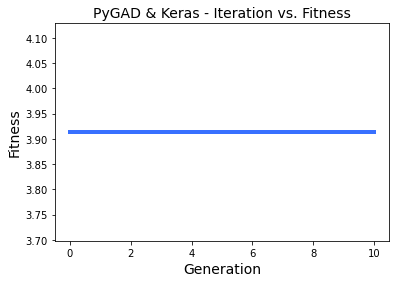

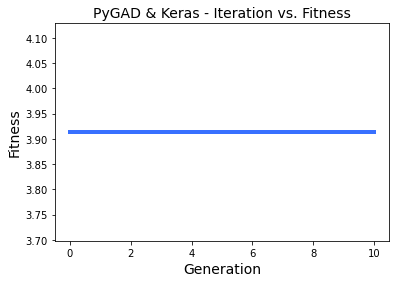

In [16]:
ga_instance.plot_result(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

In [17]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))


Fitness value of the best solution = 3.9134794025208364
Index of the best solution : 0


In [18]:
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,weights_vector=solution)

In [19]:
model.set_weights(best_solution_weights)
predictions = model.predict(data_inputs)
print("Predictions : \n", predictions)

16/16 [==============================] - 0s 2ms/step
Predictions : 
 [[ 1.55556291e-01]
 [ 1.12971723e-01]
 [ 1.28077537e-01]
 [ 1.23951584e-01]
 [ 1.96517289e-01]
 [ 2.65179425e-01]
 [ 2.74980545e-01]
 [ 1.89668149e-01]
 [ 5.27769327e-02]
 [-3.92310321e-02]
 [-7.76984096e-02]
 [-8.52853358e-02]
 [-7.58957267e-02]
 [-1.59231335e-01]
 [-2.55978644e-01]
 [-2.37523675e-01]
 [-1.59112275e-01]
 [-1.21814609e-01]
 [-7.18278587e-02]
 [-9.45284367e-02]
 [-1.76023841e-01]
 [-2.06794500e-01]
 [-1.58425838e-01]
 [-6.13268912e-02]
 [-7.65144825e-03]
 [-2.42795050e-02]
 [-2.70577669e-02]
 [-7.17560053e-02]
 [-9.04530287e-04]
 [ 1.55903101e-01]
 [ 2.47276515e-01]
 [ 2.31317073e-01]
 [ 2.48207331e-01]
 [ 3.04722309e-01]
 [ 3.45662087e-01]
 [ 4.46422994e-01]
 [ 5.52929521e-01]
 [ 5.02664685e-01]
 [ 5.31051874e-01]
 [ 5.61334312e-01]
 [ 5.62364459e-01]
 [ 5.47313213e-01]
 [ 5.60685396e-01]
 [ 5.59627175e-01]
 [ 5.18455088e-01]
 [ 4.38184679e-01]
 [ 4.18309152e-01]
 [ 4.54781175e-01]
 [ 5.30068874e-01]


In [20]:
training_model.metrics(hidden_layer_sizes=[],observado=data_outputs,prediccion=predictions)

{'hidden_layer_sizes': [],
 'map': [0.8342640788870059],
 'mae': [0.4618645715136375],
 'rmse': [0.5054968601195103],
 'r2': [-6.0090890255694935]}